In [23]:
from autograd import grad
import autograd.numpy as np
import matplotlib.pyplot as plt
from lista import LISTA, make_loss
from functions import *
from copy import deepcopy

In [24]:
layers = np.logspace(0, 1.5, 4, dtype=int)
n_samples = 1000
n_test = 100
k = 10
p = 3
K = np.eye(p)
fit_loss = 'logreg'
reg = None




fit_function, der_function = {
                              'l2': (l2_fit, l2_der),
                              'logreg': (logreg_fit, logreg_der)
                              }[fit_loss]
reg_function, prox = {
                      'l2': (l2_pen, l2_prox),
                      'l1': (l1_pen, l1_prox),
                      None: (no_pen, no_prox)
                      }[reg]
loss = make_loss(fit_function, reg_function)

z_true = np.random.randn(p, n_samples)
D = np.random.randn(k, p).dot(K)
D /= np.linalg.norm(D, axis=0, keepdims=True)

sigma = 0.1
eps = np.random.randn(k, n_samples)

z_test = np.random.randn(p, n_test)
eps_test = np.random.randn(k, n_test)
X = np.dot(D, z_true) + eps
X_test = np.dot(D, z_test) + eps_test
if fit_loss == 'logreg':
    X = 2 * (X > 0) - 1
    X_test = 2 * (X_test > 0) - 1
lbda_max = np.max(np.abs(np.dot(D.T, X)))
lbda = 0.02 * lbda_max
print('lambda = %.2e' % lbda)

lambda = 5.63e-02


In [43]:
ista_init = LISTA(D, lbda, 1, fit_loss, reg, variables='both')
ista_init.fit(X, l_rate=1., max_iter=1000, verbose=True)
init_weights = ista_init.weights

it 0, loss = 5.427e+00, grad = 2.34e-01
it 100, loss = 4.540e+00, grad = 3.49e-02
it 200, loss = 4.485e+00, grad = 1.42e-02
it 300, loss = 4.475e+00, grad = 6.71e-03
it 400, loss = 4.473e+00, grad = 3.37e-03
it 500, loss = 4.472e+00, grad = 1.74e-03
it 600, loss = 4.472e+00, grad = 9.12e-04
it 700, loss = 4.472e+00, grad = 4.81e-04
it 800, loss = 4.472e+00, grad = 2.55e-04
it 900, loss = 4.472e+00, grad = 1.35e-04


In [44]:
ista = LISTA(D, lbda, 20000, fit_loss, reg)
ista.L /= k
L = ista.L
z_hat = ista.transform(X)
f_min = loss(z_hat, X, D, lbda)

print(np.linalg.norm(z_hat - prox(z_hat - np.dot(D.T / L, der_function(np.dot(D, z_hat), X)), lbda / L)))
print(f_min)

0.37258573421407204
4.011672994611447


In [51]:
L_LIST = {}
for variables in ['both']:
    loss_list = {'ista': [], 'lista': []}
    for j, n_layers in enumerate(layers):
        print('%d layers' % n_layers)
        lista = LISTA(D, lbda, n_layers, fit_loss, reg, variables=variables)
        lista.weights[:2] = init_weights
        loss_list['ista'].append(loss(lista.transform(X), X, D, lbda))
        # smart init
        if j > 0:
            lista.weights[:len(old_weights)] = old_weights
        lista.fit(X, l_rate=0.1, max_iter=1000)
        loss_list['lista'].append(loss(lista.transform(X), X, D, lbda))
        old_weights = deepcopy(lista.weights)
    L_LIST[variables] = loss_list

1 layers
3 layers
10 layers
31 layers


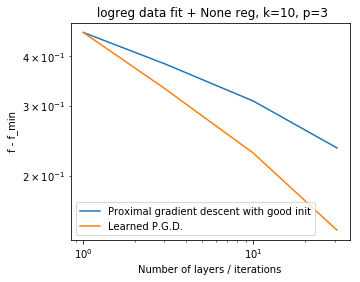

In [52]:
plt.figure(figsize=(5, 4))
title = ' %s data fit + %s reg, k=%d, p=%d' % (fit_loss, reg, k, p)
plt.title(title)
plt.plot(layers, np.array(loss_list['ista']) - f_min, label='Proximal gradient descent with good init')
plt.plot(layers, np.array(L_LIST['both']['lista']) - f_min, label='Learned P.G.D.')
plt.xlabel('Number of layers / iterations')
plt.ylabel('f - f_min')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.savefig(title + '.pdf')
plt.show()